In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from googletrans import Translator, constants
from pprint import pprint
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import textdistance 

In [2]:
# Store url of the book from the project gutenberg website
url = 'https://www.gutenberg.org/files/514/514-h/514-h.htm'

In [3]:
# Make the request and check object type
r = requests.get(url)
type(r)

requests.models.Response

In [4]:
# Extract HTML from Response object and print
html = r.text
print(html)

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">
<HTML>
<HEAD>

<META HTTP-EQUIV="Content-Type" CONTENT="text/html; charset=iso-8859-1">

<TITLE>
The Project Gutenberg E-text of Little Women, by Louisa May Alcott
</TITLE>

<STYLE TYPE="text/css">
BODY { color: Black;
       background: White;
       margin-right: 10%;
       margin-left: 10%;
       font-family: "Times New Roman", serif;
       text-align: justify }

<PRE { font-size: small ;
       font-family: "Times New Roman", serif; }

P {text-indent: 4% }

P.noindent {text-indent: 0% }

P.poem {text-indent: 0%;
        margin-left: 10%;
        font-size: small }

P.letter {text-indent: 0%;
          font-size: small ;
          margin-left: 10% ;
          margin-right: 10% }

P.finis { text-align: center ;
          text-indent: 0% ;
          margin-left: 0% ;
          margin-right: 0% }

</STYLE>

</HEAD>

<BODY>


<pre>

The Project Gutenberg EBook of Little Women, by Louisa May Alcott

<table summary="" styl

In [5]:
# Create a BeautifulSoup object from the HTML
soup = BeautifulSoup(html, "html5lib")
type(soup)

bs4.BeautifulSoup

In [6]:
# scrape title as a string
soup.title.string

'\nThe Project Gutenberg E-text of Little Women, by Louisa May Alcott\n'

In [7]:
paragraph=soup.find_all("p")
new_var = ""   
for para in paragraph:       
    new_var += para.text   
    new_var

print(new_var)


"Christmas won't be Christmas without any presents," grumbled Jo, lying
on the rug.

"It's so dreadful to be poor!" sighed Meg, looking down at her old
dress.

"I don't think it's fair for some girls to have plenty of pretty
things, and other girls nothing at all," added little Amy, with an
injured sniff.

"We've got Father and Mother, and each other," said Beth contentedly
from her corner.

The four young faces on which the firelight shone brightened at the
cheerful words, but darkened again as Jo said sadly, "We haven't got
Father, and shall not have him for a long time." She didn't say
"perhaps never," but each silently added it, thinking of Father far
away, where the fighting was.

Nobody spoke for a minute; then Meg said in an altered tone, "You know
the reason Mother proposed not having any presents this Christmas was
because it is going to be a hard winter for everyone; and she thinks we
ought not to spend money for pleasure, when our men are suffering so in
the army.  We can't

# Word frequency analysis 



In [75]:
#tokenize the text i.e. spliting into words/removing whitespace
# Create tokenizer
tokenizer = RegexpTokenizer('\w+')

# Create tokens
tokens = tokenizer.tokenize(new_var)

#inspect slice of data
tokens[5:10]

['without', 'any', 'presents', 'grumbled', 'Jo']

In [76]:
#make all tokens lower case to prevent double counting later on

# Initialize new list
words = []


# Loop through list tokens and make lower case
for word in tokens:
    words.append(word.lower())


# inspect slice of data
words[10:20]

['lying', 'on', 'the', 'rug', 'it', 's', 'so', 'dreadful', 'to', 'be']

In [10]:
#remove stopwords
# Get English stopwords 
sw = nltk.corpus.stopwords.words('english')


#create new list without stop words
words_ns = []

# Add all words that are not stopwords
for word in words:
    if word not in sw:
        words_ns.append(word)

# inspect first few items
words_ns[:5]

['christmas', 'christmas', 'without', 'presents', 'grumbled']

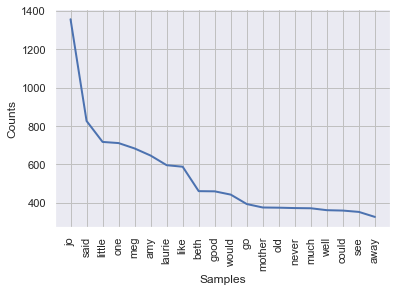

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [11]:
#visualize word frequency

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# plot frequency distribution for top 20 most used words
freqdist1 = nltk.FreqDist(words_ns)
freqdist1.plot(20)

#we can see that the most frequently used word in the book was Jo 

# Mini "Auto-correct" function
## create a mini "auto-correct" function using the book as a database of words to find the closest match 

In [20]:
#create dict for word freq

word_freq_dict = {}  
word_freq_dict = Counter(words_ns)
print(word_freq_dict.most_common()[0:10])

[('jo', 1355), ('said', 826), ('little', 717), ('one', 711), ('meg', 683), ('amy', 646), ('laurie', 596), ('like', 588), ('beth', 461), ('good', 460)]


In [37]:
#find the relative frequency of words
probs = {}     
Total = sum(word_freq_dict.values())    
for k in word_freq_dict.keys():
    probs[k] = word_freq_dict[k]/Total

In [70]:
#define autocorrect function 

def mini_autocorrect(input_word):
    input_word = input_word.lower()
    if input_word in words_ns:
        return("That's a match")
    else:
        #sort similar words according to the Jaccard distance 
        similarities = [1-(textdistance.Jaccard(qval=2).distance(v,input_word)) for v in word_freq_dict.keys()]
        df = pd.DataFrame.from_dict(probs, orient='index').reset_index()
        df = df.rename(columns={'index':'Word', 0:'Prob'})
        df['Similarity'] = similarities
        output = df.sort_values(['Similarity', 'Prob'], ascending=False).head()
        #return the 5 most similar words ordered by probability:
        print('did you mean to say:')
        return(output)
    

In [71]:
#test the function
mini_autocorrect('joey')

did you mean to say:


,Word,Prob,Similarity
4,jo,0.015097,0.333333
1041,journey,0.000145,0.285714
2657,eye,0.000368,0.250000
1221,joy,0.000201,0.250000
1650,key,0.000111,0.250000


In [52]:
mini_autocorrect('amy')

"That's a match"

# Translate text using google API


In [12]:

#init Google API translator
translator = Translator()

#translate the last paragraph of text into mandarin (simplified)
#google API translator has a limit of 5,000 characters per request for its free service

translation = translator.translate(para.text, dest="zh-CN")
print("The Mandarin translation is: ",translation.text)

#english version 
print("The original english version was: ",para.text)

The Mandarin translation is:  “哦，我的女孩们，无论您能活多久，我永远都不会希望您
比这更大的幸福！”
The original english version was:  
"Oh, my girls, however long you may live, I never can wish you a
greater happiness than this!"

